In [26]:
# Imports for alpaca and .env 
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
import os
from pathlib import Path
load_dotenv()

True

In [27]:
# Set Alpca API key and secret key, then insantiate an API object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECURITY_KEY")

tradeapi = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


In [28]:
from datetime import date
import re
# Define functions I use to get Alpaca Trade API data
def calc_start_date(years_ago):
    """Calculates the date 'x' years ago"""
    to_day=str(date.today())
    match = re.match(r'(\d\d\d\d)-(\d\d)-(\d\d)', to_day)
    _yrsago= int(match.group(1))-years_ago
    _yrsago = str(_yrsago)+'-'+match.group(2)+'-'+match.group(3)
    return _yrsago

def get_company(ticker, start, end, tradeapi):
    """Executes the get_bars method from Alpaca Trade API"""
    return tradeapi.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

# Get Data from API:
spy_df = get_company("SPY", calc_start_date(20), "2022-03-30", tradeapi)
spy_df.reset_index(inplace=True)
# spy_df.to_csv("../Data/rawdata/SPY_data.csv")


<AxesSubplot:>

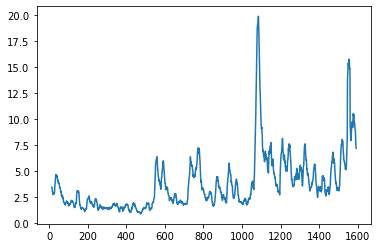

In [29]:
import pandas as pd
import numpy as np
# make a df with the values needed for the ATR calculation:
range_df = { 
               "date": spy_df['timestamp'] , 
               "hi-lo": abs( spy_df['high']-spy_df['low'] ), 
                "hi-cl": abs( spy_df['high'] - spy_df['close'].shift() ),
                "lo-cl": abs( spy_df['low'] - spy_df['close'].shift() )
}
# make a df out of our rage_df dictionary
range_df = pd.DataFrame(range_df)
# NaN exist because it subtracts the prior day's close, which doesn't exist in row one. Not important.
range_df.dropna(inplace=True)
range_df.set_index('date', inplace= True)

# Make a df of the maximum of ranges
true_range = pd.DataFrame( np.max(range_df, axis = 1) )
true_range.rename(columns= {0:'TR'}, inplace=True)
true_range.reset_index(inplace=True)

#plot a 14 day moving average of True Range (ATR)
true_range['TR'].rolling(14).mean().plot()




In [30]:

true_range.head()
true_range.to_csv("Data/rawdata/TR_data.csv")

In [50]:
vix_df = pd.read_csv('Data/cleandata/VIX_data.csv', index_col= 'timestamp')
spy_df = pd.read_csv('Data/cleandata/SPY_data.csv', index_col= 'timestamp')
my_price = spy_df.tail(1)['close'][0]


In [34]:
import Data.DataWrangle as dw
spy_df.drop(labels='id',axis=1, inplace= True)
combined_df = dw.combine_DFs([spy_df,vix_df],['SPY','VIX'])
combined_df.sort_index(inplace=True)
combined_df.dropna(inplace=True)




SPY                                                       \
              open      high       low   close       volume trade_count   
timestamp                                                                 
2015-12-01  209.42  210.8200  209.1100  210.68   97858418.0    337780.0   
2015-12-02  210.60  211.0000  208.2300  208.54  108069059.0    367013.0   
2015-12-03  208.90  209.1500  204.7511  205.58  166224154.0    546768.0   
2015-12-04  206.10  209.9700  205.9300  209.66  192878747.0    556731.0   
2015-12-07  209.20  209.7295  207.2000  208.27  102027111.0    374705.0   

                          VIX                       
                  vwap   open   high    low  close  
timestamp                                           
2015-12-01  209.921410  15.61  16.34  14.63  14.67  
2015-12-02  209.563055  15.04  16.49  14.71  15.91  
2015-12-03  206.878936  15.87  19.35  15.86  18.11  
2015-12-04  208.178631  17.43  17.65  14.69  14.81  
2015-12-07  208.276128  15.65  17.18  15.58  15.84

In [39]:
from MCForecastTools import MCSimulation as MCsim

my_sim = MCsim(
    portfolio_data = combined_df,
    weights = [1,0],
    num_simulation = 100,
    num_trading_days = 252*2
)

<AxesSubplot:title={'center':'100 Simulations of Cumulative Portfolio Return Trajectories Over the Next 504 Trading Days.'}>

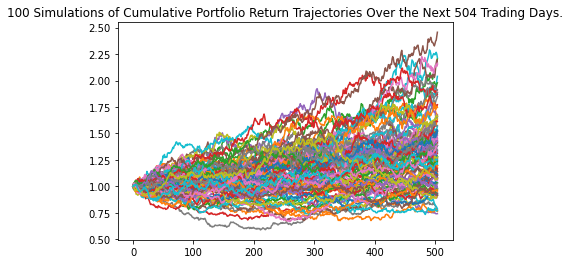

In [53]:
my_returns = my_sim.simulated_return
my_sim.plot_simulation()

<AxesSubplot:title={'center':'MC SIM of S&P 500'}>

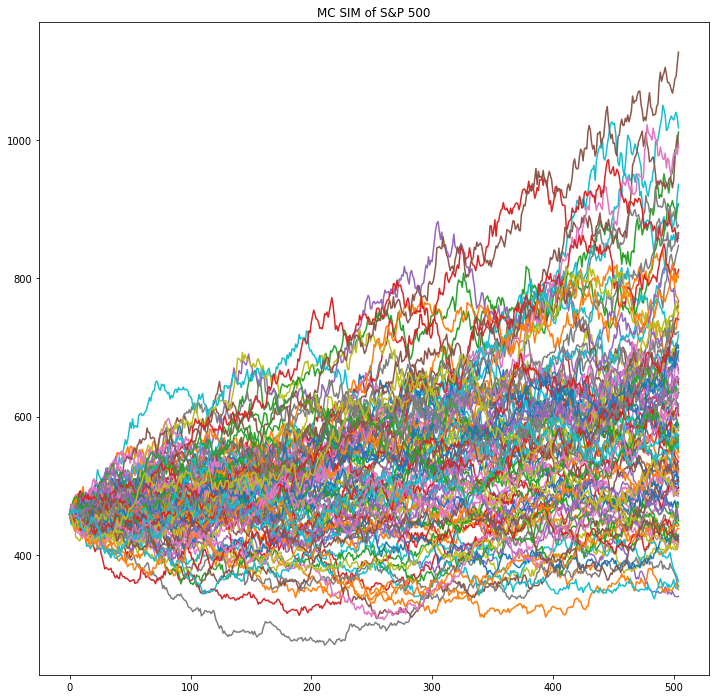

In [70]:
my_returns.iloc[0]= 1
(my_returns*my_price).plot(legend=None, title= 'MC SIM of S&P 500', figsize= (12,12))